In [43]:
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import feather
import statsmodels.api as sm 
import numpy as np
import feather
import geopandas as gpd 
import warnings
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Wedge
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 22})

c= ['Bosnia and Herz.', 'Central African Rep.',"Côte d'Ivoire", 'Dem. Rep. Congo', "eSwatini", "Laos", 'Macedonia', 'Moldova', 'North Korea', 
'Russia','South Korea', 'Syria', 'Tanzania', 'Vietnam', "United Kingdom"]

mustfix = ["Bosnia and Herzegovina", "Central African Republic", "Côte d'Ivoire", "Democratic Republic of the Congo","Eswatini", "Lao People's Democratic Republic",
           "North Macedonia", "Republic of Moldova", "Democratic People's Republic of Korea", "Russian Federation", "Republic of Korea", 
           "Syrian Arab Republic", "United Republic of Tanzania", "Viet Nam", "United Kingdom of Great Britain and Northern Ireland"]

changes = pd.DataFrame({"country": mustfix, "fixed":c})

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.rename({"name":"country"}, axis=1)
mollweide_proj = '+proj=moll +lon_0=0'

countries = countries.to_crs(mollweide_proj)
countries = countries[countries['continent']!= "Antarctica"]
countries.loc[countries.country=="France", 'iso_a3'] = "FRA"
countries.loc[countries.country=="Norway", 'iso_a3'] = "NOR"

combined = pd.read_pickle("./data/combined.pkl").dropna()

In [2]:
combined['country'] = [x.split(',')[0] for x in combined['country']]
combined['country'] = [x.split(' (')[0] for x in combined['country']]
combined = combined.merge(changes, how="left")
combined.loc[combined.fixed.notnull(), 'country'] = combined.fixed

### R2 maps

In [3]:
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    residual_var = result.mse_resid
    return pd.Series([result.params[0], result.rsquared, residual_var])

regs = combined.groupby(['country', 'cropname']).apply(regress, 'yield', ['csif'])
regs.columns=["sif_coefficient", "r2", "resid_var"]
regs = regs.reset_index().dropna()
regs.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
#regs.to_pickle("./data/combined_regs.pkl")  
regs["resid_var"]=regs["resid_var"].astype(str)
path = './data/combined_regs.feather'
#feather.write_dataframe(regs, path)

In [4]:
regs2 = regs.copy()
regs2.loc[regs2['sif_coefficient']>0, 'sif_coefficient'] = 1
regs2.loc[regs2['sif_coefficient']<0, 'sif_coefficient'] = -1
regs2a = regs2.groupby('country')['sif_coefficient'].agg(pd.Series.mode).reset_index(
).explode('sif_coefficient').groupby('country').mean().reset_index()
regs2b = regs2.groupby('country')['r2'].mean().reset_index()
regs_avg = regs2a.merge(regs2b)
regs_best = regs.loc[regs.groupby('country')["r2"].idxmax()]

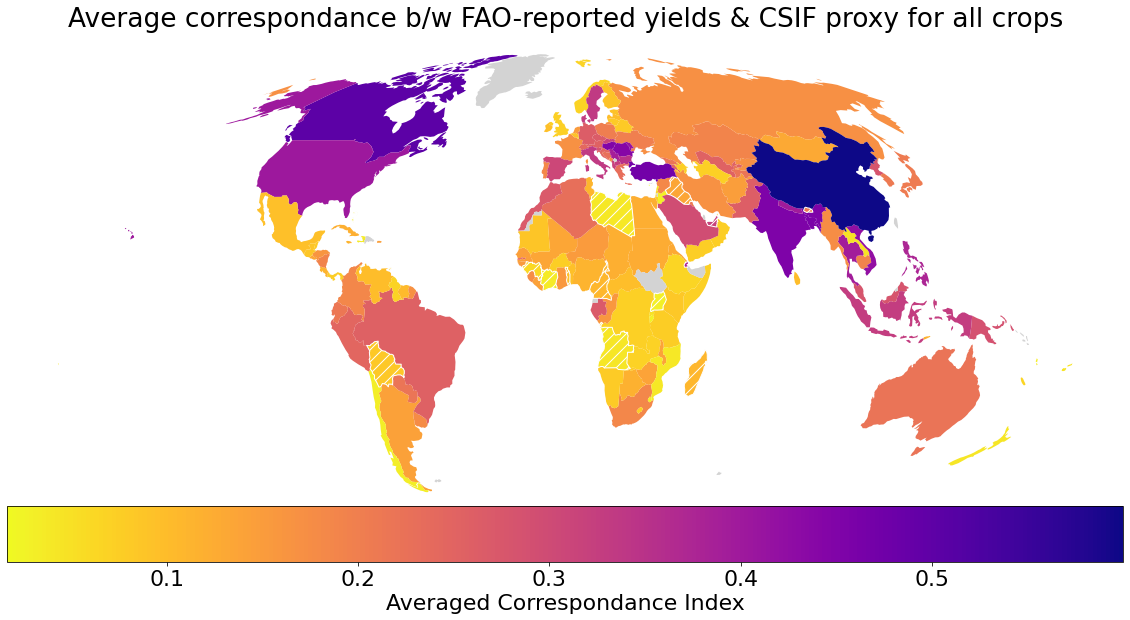

In [61]:
df = regs_avg
ack = countries.merge(df, how="left")
ack.loc[ack.sif_coefficient < 1, "pos_neg"] = "neg"

fig, ax = plt.subplots(1, 1, figsize=(20,15)) 
ax.set_title("Average correspondance b/w FAO-reported yields & CSIF proxy for all crops")
ack.plot(column="r2",legend=True,
               legend_kwds={'label': "Averaged Correspondance Index",
                        'orientation': "horizontal",
                           'pad': -0.01}, cmap="plasma_r", 
              missing_kwds={'color': 'lightgrey'}, ax=ax)
ack.loc[ack.sif_coefficient<1].plot(column="pos_neg", hatch = "//", ax=ax, facecolor="none", edgecolor="white")
plt.axis('off')
plt.savefig("./plots/avg_corr_map.pdf", bbox_inches='tight')

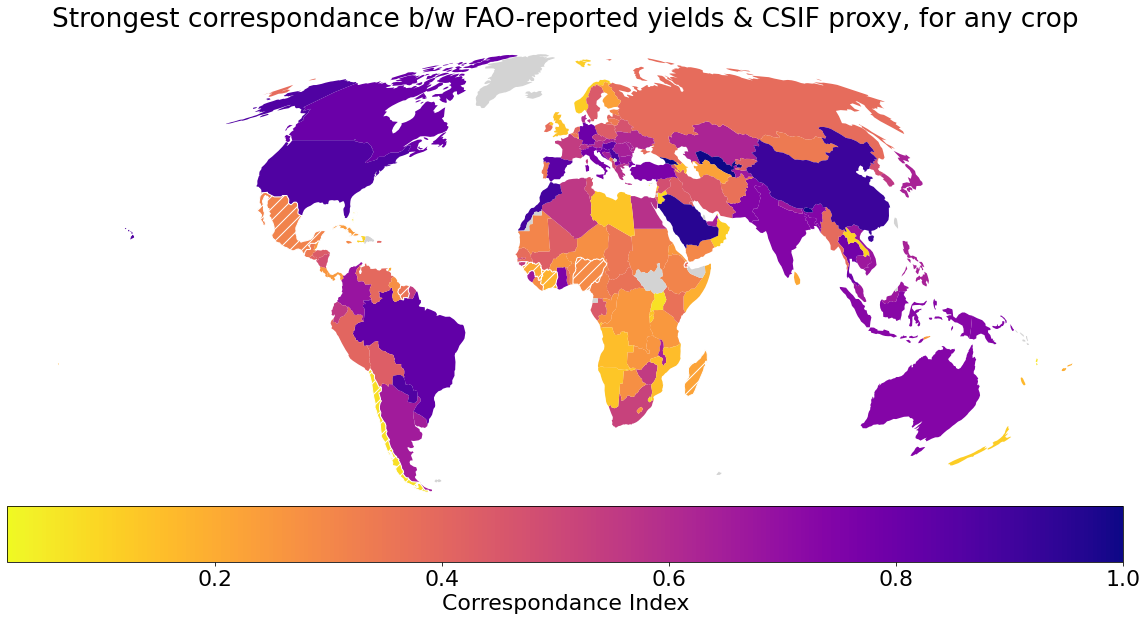

In [64]:
df = regs_best.copy()
ack = countries.merge(df, how="left")
ack.loc[ack.sif_coefficient < 0, "pos_neg"] = "neg"

fig, ax = plt.subplots(1, 1, figsize=(20,15)) 
ax.set_title("Strongest correspondance b/w FAO-reported yields & CSIF proxy, for any crop")
ack.plot(column="r2",legend=True,
               legend_kwds={'label': "Correspondance Index",
                        'orientation': "horizontal",
                            'pad': -0.01,}, cmap="plasma_r",                         
              missing_kwds={'color': 'lightgrey'}, ax=ax)
ack.loc[ack.sif_coefficient<0].plot(column="pos_neg", hatch = "//", ax=ax, facecolor="none", edgecolor="white")
plt.axis('off')
plt.savefig("./plots/least_corr_map.pdf", bbox_inches='tight')

### GDP map

In [36]:
import requests
import pandas as pd

url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD"
params = {"date": "2000:2020","format": "json", "per_page": 20000}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    if len(data) > 1:
        records = data[1] 
        gdp_df = pd.DataFrame(records)
        gdp_df = gdp_df[["countryiso3code", "date", "value"]]
        gdp_df.columns = ["iso_a3", "year", "value"]
        gdp_df = gdp_df.groupby('iso_a3').mean('value').reset_index()
    else:
        print("No data found in the API response.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

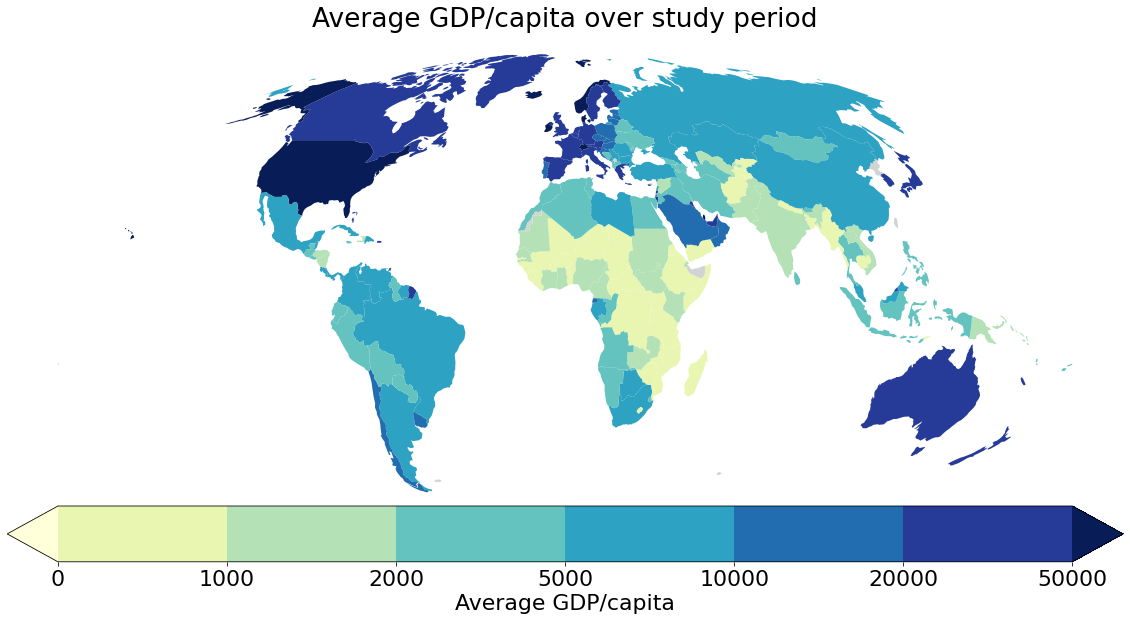

In [50]:
ack = countries.merge(gdp_df, how="left", on="iso_a3")
bounds = [0, 1000, 2000, 5000, 10000, 20000, 50000]
cmap = plt.cm.YlGnBu
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig, ax = plt.subplots(1, 1, figsize=(20,15)) 
ax.set_title("Average GDP/capita over study period")
ack.plot(column="value", legend=True, cmap="YlGnBu", norm=norm,
         missing_kwds={'color': 'lightgray'}, ax=ax,
           legend_kwds={'label': "Average GDP/capita",
            'orientation': "horizontal", 
               'pad': -0.01,})
plt.axis('off')
plt.savefig("./plots/avg_gdp_map.pdf", bbox_inches='tight')

### lead/lag inconsistency

In [7]:
newcolors = ["#ffcba4", "#ca8af2", "#84d7bb"]
newcmp = ListedColormap(newcolors)

In [8]:
cdf = combined[["cropname", "country", "whichlag"]].drop_duplicates().reset_index(drop=True)
grouped = cdf.groupby('country')['whichlag'].value_counts(normalize=True)
grouped = grouped.round(2)
grouped = pd.DataFrame(grouped).rename(columns={'whichlag':'pct'}).reset_index()

In [9]:
df = grouped.merge(changes, how="left")
df.loc[df.fixed.notnull(), 'country'] = df.fixed
df = df[["country", 'whichlag', 'pct']].drop_duplicates()
ack = countries.merge(df, how="left")

In [10]:
rowmax = ack.groupby('country')['pct'].idxmax()#.dropna()
keepna = rowmax[np.isnan(rowmax)]

p1 = ack.loc[rowmax.dropna()]
p2 = ack[ack['country'].isin(keepna.index)]
plot1 = gpd.GeoDataFrame( pd.concat( [p1, p2], ignore_index=True) )

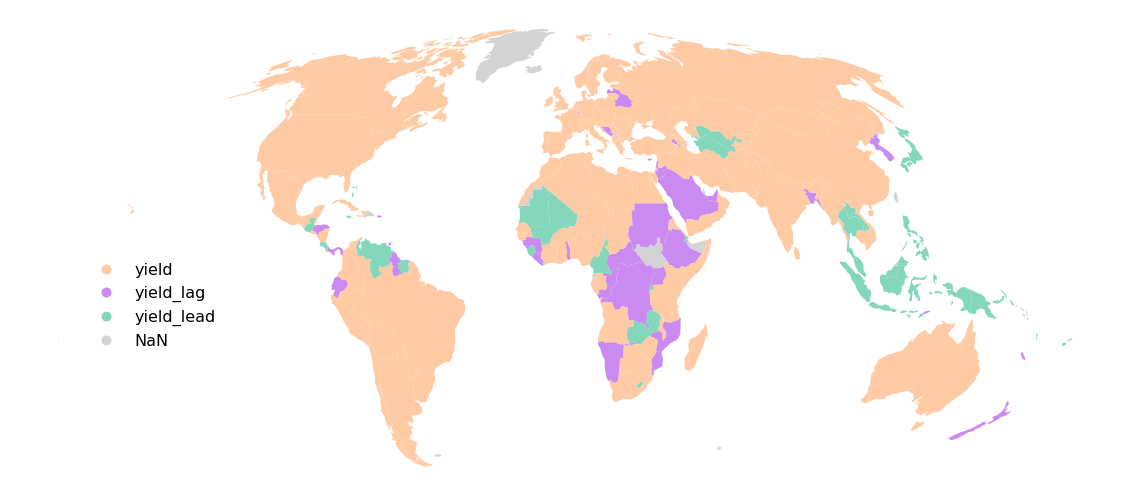

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20,15)) 
plot1.plot(column="whichlag", legend=True, categorical=True, cmap = newcmp, 
         legend_kwds={'bbox_to_anchor':(0.2, 0.5),'fontsize':16,'frameon':False},
         missing_kwds={'color': 'lightgray'}, ax=ax)
plt.axis('off')
plt.savefig("./plots/leadlag_map.pdf", bbox_inches='tight')

In [48]:
africa_lags =  ack[ack['continent']=="Africa"][["country", "iso_a3", "whichlag", "pct"]]
africa_lags 
africa_lags.to_csv('./data/africa_lags.csv', index=False) 


### map % of crops that are lead or lag

In [56]:
df = grouped.merge(changes, how="left")
df.loc[df.fixed.notnull(), 'country'] = df.fixed
df = df[["country", 'whichlag', 'pct']].drop_duplicates()
df['whichlag'] = df['whichlag'].replace({'yield_lag': 'lead/lag', 'yield_lead': 'lead/lag'})
df = df.groupby(['country', 'whichlag']).sum('pct').reset_index()
df = df[df['whichlag']=="lead/lag"]
df['pct'] = 1-df['pct']
plot2 = countries.merge(df, how="left")

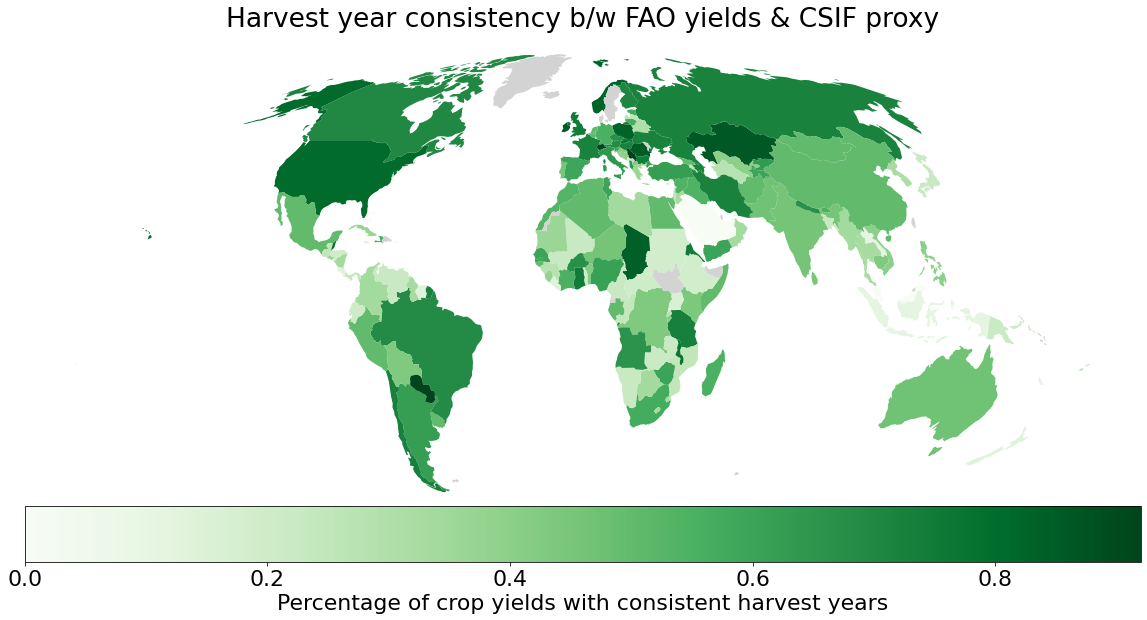

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(20,15)) 
ax.set_title("Harvest year consistency b/w FAO yields & CSIF proxy")
plot2.plot(column="pct", legend=True, cmap= "Greens",
         missing_kwds={'color': 'lightgray'}, ax=ax,
           legend_kwds={'label': "Percentage of crop yields with consistent harvest years",
            'orientation': "horizontal", 
               'pad': -0.01,})
plt.axis('off')
plt.savefig("./plots/leadlag_pct_map.pdf", bbox_inches='tight')